In [1]:
# Magic functions -- Run Once
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Move up one folder to reach the repo root
%cd ..

from utils.notebook.generic import full_width_notebook

full_width_notebook()

/home/abdj2702/dev/maitrise/film-aqa


In [14]:
# Paths, Imports & Configs
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
from utils.notebook.experiment_explorer import get_experiments

from utils.notebook.pandas import sub_cols_with_cond_and_create_new_col, grouped_scatter, groupby_mean, convert_cols_to_int

root_data_path = "data"
#root_output_path = "output/training"
#root_output_path = "/archive/abdj2702/training_limited_0.85"
root_output_path = "output/synced_training"

# Helpers column selectors
run_info_columns = ['prefix', 'nb_sample', 'config', 'nb_epoch_trained', 'stopped_early']
more_accuracy_info_columns = ['0.6_at_epoch', '0.7_at_epoch', '0.8_at_epoch', '0.9_at_epoch']
accuracy_columns = ['best_val_acc', 'train_acc', 'test_acc']
loss_columns = ['best_val_loss', 'train_loss', 'test_loss']
all_training_stats = ['all_train_acc', 'all_train_loss', 'all_val_acc', 'all_val_loss']
model_config_columns = ['nb_trainable_param', 'word_embedding_dim', 'rnn_state_size', 'extractor_type', 
                        'stem_out_chan', 'nb_resblock', 'resblocks_out_chan', 'classifier_conv_out_chan', 
                        'classifier_type', 'classifier_global_pool', 'nb_answer']
optimizer_columns = ['optimizer_type', 'optimizer_lr', 'optimizer_weight_decay', 'dropout_drop_prob']
preprocessing_columns = ['pad_to_largest', 'resized_height', 'resized_width']
timing_columns = ['train_time', 'mean_epoch_time']
other_columns = ['nb_scene', 'nb_q_per_scene', 'date', 'batch_size', 'resnet_features', 'test_version', 
                 'random_seed', 'nb_non_trainable_param', 'total_nb_param', 'nb_epoch', 'stop_accuracy', 'folder', 'gpu_name']

# Retrieve all experimentsi infos
experiments = get_experiments(root_output_path)

# Pretty printing
format_dict = {
    'total_nb_param': "{:,d}".format,
    'nb_non_trainable_param': "{:,d}".format,
    'nb_trainable_param': "{:,d}".format,
    'nb_trainable_param_round': "~ {:,d}".format,
    'nb_sample': "{:,d}".format,
    'nb_scene': "{:,d}".format,
    'rnn_state_size': "{:,d}".format,
    'optimizer_lr': "{:.2e}".format,
    'optimizer_weight_decay': "{:.2e}".format,
    'best_val_acc': lambda x: "{:.2f}%".format(x*100) if not pd.isnull(x) else None,
    'train_acc': lambda x: "{:.2f}%".format(x*100) if not pd.isnull(x) else None,
    'test_acc': lambda x: "{:.2f}%".format(x*100) if not pd.isnull(x) else None,
    '0.6_at_epoch': lambda x: x if not pd.isnull(x) else None,
    '0.7_at_epoch': lambda x: x if not pd.isnull(x) else None,
    '0.8_at_epoch': lambda x: x if not pd.isnull(x) else None,
    '0.9_at_epoch': lambda x: x if not pd.isnull(x) else None
}

latex_format_dict = deepcopy(format_dict)
latex_format_dict['nb_sample'] = lambda x: "{:d}k".format(x//1000)
latex_format_dict['nb_scene'] = lambda x: "{:d}k".format(x//1000)
latex_format_dict['best_val_acc'] = lambda x: "{:.2f}".format(x*100) if not pd.isnull(x) else None
latex_format_dict['train_acc'] = lambda x: "{:.2f}".format(x*100) if not pd.isnull(x) else None
latex_format_dict['test_acc'] = lambda x: "{:.2f}".format(x*100) if not pd.isnull(x) else None
latex_format_dict['classifier_type'] = lambda x: 'Fcn' if x == 'fcn' else 'Conv-Avg'
latex_format_dict['classifier_conv_out'] = lambda x: '{:d}'.format(int(x)) if not pd.isnull(x) else "--"
latex_format_dict['classifier_projection_out'] = lambda x: '{:d}'.format(int(x)) if not pd.isnull(x) else "--"
latex_format_dict['extractor_projection_size'] = lambda x: '{:d}'.format(int(x)) if not pd.isnull(x) else "--"
latex_format_dict['extractor_filters'] = lambda x: str(x)[1:-1]  # Remove the '[' and ']' of str(array)

# Round number params to the closest thousand to facilitate comparison
experiments['nb_trainable_param_round'] = experiments['nb_trainable_param'].apply(lambda x: x//1000 * 1000)

pd.set_option('display.max_colwidth', -1)

exp_results_cols = run_info_columns + ['nb_scene', 'nb_q_per_scene'] + accuracy_columns + more_accuracy_info_columns + ['nb_trainable_param_round', 'note']
exp_results = experiments[exp_results_cols].sort_values(['nb_scene', 'test_acc'], ascending=[True, False])

experiments.columns.values


0 -- 0.37543
1 -- 0.385
2 -- 0.4063
3 -- 0.43803
4 -- 0.4726
5 -- 0.482
6 -- 0.49933
7 -- 0.54337
8 -- 0.5951
9 -- 0.65523
10 -- 0.70307
11 -- 0.7418
12 -- 0.7862
13 -- 0.79943
14 -- 0.79967
15 -- 0.80187
16 -- 0.8063
17 -- 0.8048
18 -- 0.8175
19 -- 0.8293
20 -- 0.82157
21 -- 0.82783
22 -- 0.83687
23 -- 0.83037
24 -- 0.84067
25 -- 0.83923


array(['prefix', 'nb_scene', 'nb_q_per_scene', 'config', 'nb_epoch',
       'stop_accuracy', 'random_seed', 'date', 'folder', 'note',
       'nb_sample', 'nb_epoch_runned', 'nb_epoch_trained', 'best_val_acc',
       'best_val_loss', 'train_acc', 'train_loss', 'all_train_acc',
       'all_train_loss', 'all_val_acc', 'all_val_loss', 'train_time',
       '0.6_at_epoch', '0.7_at_epoch', '0.8_at_epoch', '0.9_at_epoch',
       'mean_epoch_time', 'test_version', 'test_acc', 'test_loss',
       'stopped_early', 'total_nb_param', 'nb_trainable_param',
       'nb_non_trainable_param', 'batch_size', 'resnet_features',
       'pad_to_largest', 'resized_height', 'resized_width', 'nb_answer',
       'git_revision', 'word_embedding_dim', 'rnn_state_size',
       'extractor_type', 'extractor_out_chan', 'extractor_filters',
       'extractor_nb_block', 'extractor_projection_size', 'stem_out_chan',
       'nb_resblock', 'resblocks_out_chan', 'classifier_projection_out',
       'classifier_type', 'classi

In [ ]:
experiments[experiments['config'].str.contains("3_block_64_proj")].sort_values('test_acc', ascending=False)[exp_results_cols].style.format(format_dict)

In [ ]:
set(experiments['note'].values)

In [ ]:
#experiments[experiments['note'] == 'batching']['config'].values.tolist()
df_filter = (experiments['config'].isin(experiments[experiments['note'] == 'batching']['config'].values.tolist()))
df_filter &= (experiments['nb_scene'] == 50000) & (experiments['nb_q_per_scene'] == 4)
df_filter &= (experiments['note'] == 'batching') | (experiments['note'] == 'extractor')
df_filter |= ((experiments['config']=='reduction_original_rnn_4096') & (experiments['note'] == 'final_dropout'))
experiments[df_filter].drop_duplicates(subset=['config', 'nb_scene', 'nb_q_per_scene', 'note'], keep='first').sort_values('config')[exp_results_cols + ['folder']]
#experiments[experiments['note'] == 'batching'].sort_values('date', ascending=False)[exp_results_cols].style.format(format_dict)

In [ ]:
def get_delete_experiment_from_drive_script(df, dryrun=False):
    for f, d in df[['folder', 'date']].values:
        res_path = f"{f}/{d.strftime('%Y-%m-%d_%Hh%M')}"
        cmd = f"rclone delete Drive:result/training/{res_path} -P"
        if dryrun:
            cmd += " --dry-run"
        print(cmd)
        
get_delete_experiment_from_drive_script(experiments[experiments['note'] == 'resnet_noratio'], dryrun=False)

In [ ]:
experiments[((experiments['note'] == 'extractor') & (experiments['extractor_type'] == 'freq_time_interlaced'))].sort_values('test_acc', ascending=False)[exp_results_cols + ['extractor_type']].style.format(format_dict)

In [ ]:
df = groupby_mean(experiments[(experiments['note'] == 'extractor')], ['config', 'nb_sample'], ['best_val_acc', 'train_acc', 'test_acc', '0.6_at_epoch', '0.7_at_epoch', '0.8_at_epoch'], exp_results_cols, add_count_col=True)

df = convert_cols_to_int(df, ['0.6_at_epoch', '0.7_at_epoch', '0.8_at_epoch'])

df.style.format(format_dict)

In [ ]:
print("Available configs :")
set(experiments['config'].values)

In [ ]:
len(experiments.index.values)

In [ ]:
exp_results[(exp_results['note'] == 'extractor')].sort_values(['nb_sample', 'test_acc']).style.format(format_dict)

In [ ]:
df_filter = (~exp_results['config'].str.contains('film_original')) & (~exp_results['config'].str.contains('freq_time')) & (~exp_results['config'].str.contains('extractor')) & (~exp_results['config'].str.contains('resblock'))
df_filter &= (exp_results['nb_sample'] == 200000) & (~exp_results['config'].str.contains('avg')) & (exp_results['stopped_early'] != 'stop_threshold')
experiments[exp_results_cols + ['rnn_state_size']][df_filter].groupby('rnn_state_size').mean().sort_values(['test_acc'])#.style.format(format_dict)
#exp_results[df_filter].sort_values(['test_acc']).style.format(format_dict)

In [ ]:
exp_results[(exp_results['stopped_early'] == 'stop_threshold') & (~exp_results['config'].str.contains('extractor'))]

In [ ]:
#exp_results[exp_results['nb_scene'] == 50000]
#exp_results[exp_results['nb_sample'] == 200000].sort_values(['nb_scene', 'nb_q_per_scene']).style.format(format_dict)
exp_results

In [ ]:
exp_results[(exp_results['nb_scene'] <= 10000) & (exp_results['config'].str.contains('reduction'))].sort_values('test_acc').style.format(format_dict)

In [ ]:
df_filter = ((experiments['config'].str.contains('reduction')) & (~experiments['config'].str.contains('stem')) & (~experiments['config'].str.contains('extractor')) & (~experiments['config'].str.contains('resblock')) & (~experiments['config'].str.contains('avg'))) | ((experiments['config'] == 'film_original') & (exp_results['nb_scene'] == 20000) & (exp_results['nb_q_per_scene'] == 20))
reduction_experiments = experiments[experiments['config'].str.contains('reduction')][exp_results_cols + timing_columns].sort_values('config')
reduction_experiments#[reduction_experiments['stopped_early'] == 'NO']['folder'].values

In [ ]:
exp_results[(exp_results['config'].str.contains('interlaced_smallest'))].sort_values('test_acc', ascending=True).style.format(format_dict)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

def plot_training_stats(dataframe, names=None, title=None, colormap=cm.viridis, ax=None):
    nb_rows = len(dataframe.index)

    colorlist = {key: colors.rgb2hex(colormap(i)) for key, i in
                 zip(dataframe.index, np.linspace(0, 0.9, nb_rows))}

    if title is None:
        title = "Training Stats"
    
    if ax is None:
        fig, axs = plt.subplots(2,1)
        
    fig.suptitle(title)
    axs[0].set_title("Accuracy")
    axs[1].set_title("Loss")
        
    for row in dataframe.itertuples():
        label = f"{row.config} - {row.nb_scene//1000}k_{row.nb_q_per_scene}_q"
        lines = axs[0].plot(row.all_train_acc, label=f"TRAIN - {label}")
        axs[0].plot(row.all_val_acc, color=lines[0].get_color(), linestyle="--")
        
        axs[1].plot(row.all_train_loss, color=lines[0].get_color())
        axs[1].plot(row.all_val_loss, label=f"VAL - {label}", color=lines[0].get_color(), linestyle="--")
        
    # Draw legend out of the plot
    for ax in axs:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])

        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    fig.tight_layout()
    
    return fig, ax

    #for key, group in dataframe.groupby(group_key):
    #    group.plot.scatter(ax=ax, x=x_axis, y=y_axis, c=colorlist[key], label=key, title=title)
    
with_training_stats = experiments[exp_results_cols + all_training_stats]
fig, ax = plot_training_stats(with_training_stats[(with_training_stats['config'].str.contains('separated'))])

In [ ]:
plot_training_stats(with_training_stats[with_training_stats['nb_q_per_scene'] == 1])

In [ ]:
# Visualization of test_acc by (nb_sample, nb_scene)
exp_results[(~exp_results['config'].str.contains('film_original')) & (~exp_results['config'].str.contains('extractor'))].hist(column='train_acc', by=['nb_sample', 'nb_scene'])


In [ ]:


grouped_scatter(experiments, 'config', 'nb_sample', 'test_acc')

#grouped_scatter(experiments[experiments['config'] == 'film_original'], 'nb_q_per_scene', 'nb_scene', 'test_acc')

test = experiments.copy()

test['perf_delta_orig_vs_small_rnn'] = test[test['config'] == 'film_original']['test_acc'] - test[test['config'] == 'film_original_small_rnn']['test_acc']

In [ ]:
test = sub_cols_with_cond_and_create_new_col(experiments.copy(), 'perf_delta_orig_vs_small_rnn', 'test_acc', test['config'] == 'film_original_small_rnn', test['config'] == 'film_original', test['config'] == 'film_original_small_rnn')

test.sort_values(['nb_sample', 'nb_scene'], ascending=False)[run_info_columns + ['test_acc', 'perf_delta_orig_vs_small_rnn']]

In [ ]:
latex_table = experiments[experiments['config'] == 'film_original'][['nb_sample', 'nb_scene', 'nb_q_per_scene', 'train_acc', 'best_val_acc', 'test_acc', '0.8_at_epoch']].sort_values(['nb_sample', 'nb_scene']).fillna("None").to_latex(formatters=latex_format_dict)
print(latex_table)

# Table Generation

In [ ]:
## Network reduction -- GRU units
df_filter = ((experiments['note'] == 'final_dropout') & (experiments['config'].str.contains('reduction')) & (~experiments['config'].str.contains('proj')) & (~experiments['config'].str.contains('conv')) & (experiments['classifier_type'] == 'fcn'))
columns = ['nb_trainable_param', 'rnn_state_size', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']
reduction_experiments = experiments[df_filter][columns].sort_values('nb_trainable_param', ascending=False)
#print(reduction_experiments.to_latex(index=False, formatters=latex_format_dict))
reduction_experiments.style.format(latex_format_dict)

In [ ]:
## Network reduction -- Classifier
df_filter =  (experiments['note'] == 'final') & (experiments['config'].str.contains('reduction'))
df_filter &= (~experiments['config'].str.contains('extractor')) & (~experiments['config'].str.contains('proj'))
df_filter &= (experiments['rnn_state_size'].isin([4096, 1024, 256]))

columns = ['nb_trainable_param', 'rnn_state_size', 'classifier_type', 'classifier_conv_out', 'classifier_projection_out', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_trained']#, 'train_time']
# This will drop duplicates and keep the biggest test_acc of the duplicates
#reduction_experiments = experiments[df_filter].sort_values('test_acc', ascending=False).drop_duplicates(subset=['config', 'nb_scene', 'nb_q_per_scene'], keep='first')
# Sort back via trainable params
reduction_experiments = experiments[df_filter]

# Cleanup

reduction_experiments = reduction_experiments.sort_values('nb_trainable_param', ascending=False)[columns]
print(reduction_experiments.to_latex(index=False, formatters=latex_format_dict))
#reduction_experiments.style.format(latex_format_dict)

In [ ]:
## Network reduction -- Reduction Filters/Nb Resblocks
df_filter =  (experiments['note'] == 'final') & (experiments['config'].str.contains('reduction'))
df_filter &= (experiments['config'].str.contains('extractor')) & (~experiments['config'].str.contains('proj'))
df_filter &= (experiments['rnn_state_size'].isin([4096, 1024, 256]))

only_rnn_reduction_filter = (experiments['note'] == 'final') & (experiments['config'].isin(['reduction_original_rnn_1024_fcn_no_conv_hidden_256', "reduction_original_rnn_1024_fcn_conv_256_hidden_512"]))

df_filter |= only_rnn_reduction_filter

columns = ['config', 'nb_trainable_param', 'extractor_out_chan', 'stem_out_chan', 'nb_resblock', 'classifier_conv_out', 'classifier_projection_out', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']
# This will drop duplicates and keep the biggest test_acc of the duplicates
#reduction_experiments = experiments[df_filter].sort_values('test_acc', ascending=False).drop_duplicates(subset=['config', 'nb_scene', 'nb_q_per_scene'], keep='first')
# Sort back via trainable params
reduction_experiments = experiments[df_filter]

#reduction_experiments = reduction_experiments.sort_values(['rnn_state_size', 'extractor_out_chan', 'stem_out_chan', 'nb_resblock', 'classifier_conv_out', 'classifier_projection_out'], ascending=False)[columns]
#reduction_experiments = reduction_experiments.sort_values('nb_trainable_param', ascending=False)[columns]
reduction_experiments = reduction_experiments.sort_values('test_acc', ascending=False)[columns]
#print(reduction_experiments.to_latex(index=False, formatters=latex_format_dict))
reduction_experiments.style.format(latex_format_dict)

In [ ]:
## Feature Extractor -- Parallel Extractor
df_filter = (experiments['note'] == 'extractor') & (experiments['extractor_type'] == 'freq_time_separated')

columns = ['mean_epoch_time','config','nb_trainable_param', 'extractor_nb_block', 'extractor_filters', 'extractor_projection_size', 'extractor_out_chan', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']

reduction_experiments = experiments[df_filter]

# Average Results grouped over ['config', 'nb_scene', 'nb_q_per_scene']
reduction_experiments = groupby_mean(reduction_experiments, 
                                     groupby_columns=['config', 'nb_scene', 'nb_q_per_scene'],
                                     mean_columns=['train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned'],
                                    selected_columns=columns,
                                    add_count_col=False)

reduction_experiments = convert_cols_to_int(reduction_experiments, ['nb_epoch_runned'])

reduction_experiments = reduction_experiments.sort_values('mean_epoch_time', ascending=False)#[columns]
#print(reduction_experiments.to_latex(index=False, formatters=latex_format_dict))
reduction_experiments.style.format(latex_format_dict)

In [ ]:
## Feature Extractor -- Interlaced Extractor -- Time First
df_filter = (experiments['note'] == 'extractor') & (experiments['extractor_type'] == 'freq_time_interlaced')
df_filter &= (experiments['config'].str.contains('timefirst'))

columns = ['nb_trainable_param', 'extractor_nb_block', 'extractor_filters', 'extractor_projection_size', 'extractor_out_chan', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']

reduction_experiments = experiments[df_filter]

#reduction_experiments.loc[:, 'time_first'] = experiments['config'].str.contains('timefirst')

# Average Results grouped over ['config', 'nb_scene', 'nb_q_per_scene']
reduction_experiments = groupby_mean(reduction_experiments, 
                                     groupby_columns=['config', 'nb_scene', 'nb_q_per_scene'],
                                     mean_columns=['train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned'],
                                    selected_columns=columns,
                                    add_count_col=False)

reduction_experiments = convert_cols_to_int(reduction_experiments, ['nb_epoch_runned'])

reduction_experiments = reduction_experiments.sort_values('test_acc', ascending=False)#[columns]
#print(reduction_experiments.to_latex(index=False, formatters=latex_format_dict))
reduction_experiments.style.format(latex_format_dict)

In [ ]:
## Feature Extractor -- Interlaced Extractor -- Freq First
df_filter = (experiments['note'] == 'extractor') & (experiments['extractor_type'] == 'freq_time_interlaced')
df_filter &= (~experiments['config'].str.contains('timefirst'))

columns = ['nb_trainable_param', 'extractor_nb_block', 'extractor_filters', 'extractor_projection_size', 'extractor_out_chan', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']

reduction_experiments = experiments[df_filter]

#reduction_experiments.loc[:, 'time_first'] = experiments['config'].str.contains('timefirst')

# Average Results grouped over ['config', 'nb_scene', 'nb_q_per_scene']
reduction_experiments = groupby_mean(reduction_experiments, 
                                     groupby_columns=['config', 'nb_scene', 'nb_q_per_scene'],
                                     mean_columns=['train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned'],
                                    selected_columns=columns,
                                    add_count_col=False)

reduction_experiments = convert_cols_to_int(reduction_experiments, ['nb_epoch_runned'])

reduction_experiments = reduction_experiments.sort_values('nb_trainable_param', ascending=False)#[columns]
print(reduction_experiments.to_latex(index=False, formatters=latex_format_dict))
#reduction_experiments.style.format(latex_format_dict)

In [26]:
experiments['config'].apply(lambda c: 'time' if 'timefirst' in c else 'toto')

0      toto
1      toto
2      toto
3      toto
4      toto
       ... 
298    toto
299    toto
300    toto
301    toto
302    toto
Name: config, Length: 303, dtype: object

In [34]:
## Feature Extractor -- Interlaced Extractor -- Both Freq First and Time First
df_filter = (experiments['note'] == 'extractor') & (experiments['extractor_type'] == 'freq_time_interlaced')
#df_filter &= (~experiments['config'].str.contains('timefirst'))

columns = ['nb_trainable_param', 'first', 'extractor_nb_block', 'extractor_filters', 'extractor_projection_size', 'extractor_out_chan', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']

reduction_experiments = experiments[df_filter]

reduction_experiments.loc[:, 'first'] = experiments['config'].apply(lambda c: 'Time' if 'timefirst' in c else 'Frequency')

# Average Results grouped over ['config', 'nb_scene', 'nb_q_per_scene']
reduction_experiments = groupby_mean(reduction_experiments, 
                                     groupby_columns=['config', 'nb_scene', 'nb_q_per_scene'],
                                     mean_columns=['train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned'],
                                    selected_columns=columns,
                                    add_count_col=False)

reduction_experiments = convert_cols_to_int(reduction_experiments, ['nb_epoch_runned'])

reduction_experiments = reduction_experiments.sort_values(['first', 'nb_trainable_param'], ascending=False)#[columns]
print(reduction_experiments.to_latex(index=False, formatters=latex_format_dict))
#reduction_experiments.style.format(latex_format_dict)

\begin{tabular}{rlrlrrrrrr}
\toprule
nb\_trainable\_param &      first &  extractor\_nb\_block & extractor\_filters & extractor\_projection\_size &  extractor\_out\_chan & train\_acc & best\_val\_acc & test\_acc &  nb\_epoch\_runned \\
\midrule
821,958 &  Time &  4.0 &  8, 16, 32, 64 & 128 &  128 & 79.07 & 69.29 & 71.59 &  25 \\
780,934 &  Time &  4.0 &  8, 16, 32, 64 & 64 &  64 & 70.99 & 60.93 & 62.99 &  25 \\
776,774 &  Time &  4.0 &  8, 16, 32, 64 & -- &  64 & 48.73 & 47.58 & 46.71 &  15 \\
760,422 &  Time &  4.0 &  8, 16, 32, 64 & 32 &  32 & 53.79 & 49.45 & 51.05 &  20 \\
760,070 &  Time &  3.0 &  8, 16, 32 & 64 &  64 & 89.02 & 83.24 & 86.65 &  22 \\
740,582 &  Time &  3.0 &  8, 16, 32 & 32 &  32 & 89.46 & 85.55 & 86.52 &  24 \\
739,526 &  Time &  3.0 &  8, 16, 32 & -- &  32 & 80.54 & 75.95 & 80.25 &  17 \\
821,958 &  Frequency &  4.0 &  8, 16, 32, 64 & 128 &  128 & 49.03 & 47.58 & 46.67 &  17 \\
780,934 &  Frequency &  4.0 &  8, 16, 32, 64 & 64 &  64 & 48.56 & 47.41 & 46.41 &  16 

In [ ]:
## Dataset size comparison -- 100k samples

fig_name = "dataset_size_100k.pdf"
df_filter = (experiments['nb_sample'] == 100000) & (experiments['note'] == 'dataset_size')
columns = ['nb_sample', 'nb_scene', 'nb_q_per_scene']
#exp = experiments[df_filter][columns].drop_duplicates().sort_values(['nb_scene'])
experiments[df_filter][exp_results_cols]
#exp.style.format(latex_format_dict)
#print(exp.to_latex(index=False, formatters=latex_format_dict))
fig, ax = plt.subplots()
ax.set_ylim([0.4, 1.0])
ax.locator_params(integer=True)
grouped_scatter(experiments[df_filter], 'nb_scene', 'nb_q_per_scene', 'test_acc', ax = ax)
fig.savefig(f"stats/{fig_name}", bbox_inches='tight')

In [ ]:
## Dataset size comparison -- 200k samples

fig_name = "dataset_size_200k.pdf"
df_filter = (experiments['nb_sample'] == 200000) & (experiments['note'] == 'dataset_size')
columns = ['nb_sample', 'nb_scene', 'nb_q_per_scene']
#exp = experiments[df_filter][columns].drop_duplicates().sort_values(['nb_scene'])
experiments[df_filter][exp_results_cols]
#exp.style.format(latex_format_dict)
#print(exp.to_latex(index=False, formatters=latex_format_dict))
fig, ax = plt.subplots()
ax.locator_params(integer=True)
ax.set_ylim([0.4, 1.0])
grouped_scatter(experiments[df_filter], 'nb_scene', 'nb_q_per_scene', 'test_acc', ax = ax)
fig.savefig(f"stats/{fig_name}", bbox_inches='tight')

In [ ]:
## Dataset size comparison -- 400k samples

fig_name = "dataset_size_400k.pdf"
df_filter = (experiments['nb_sample'] == 400000) & (experiments['note'] == 'dataset_size')
columns = ['nb_sample', 'nb_scene', 'nb_q_per_scene']
#exp = experiments[df_filter][columns].drop_duplicates().sort_values(['nb_scene'])
experiments[df_filter][exp_results_cols]
#exp.style.format(latex_format_dict)
#print(exp.to_latex(index=False, formatters=latex_format_dict))
fig, ax = plt.subplots()
ax.locator_params(integer=True)
ax.set_ylim([0.4, 1.0])
grouped_scatter(experiments[df_filter], 'nb_scene', 'nb_q_per_scene', 'test_acc', ax = ax)
fig.savefig(f"stats/{fig_name}", bbox_inches='tight')

<IPython.core.display.Javascript object>


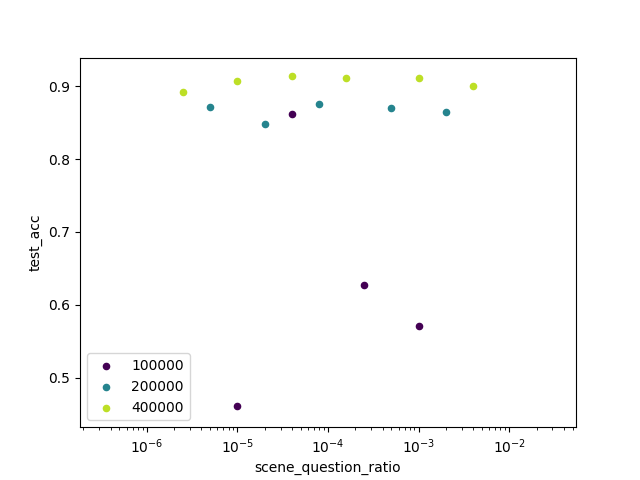

In [28]:
## Dataset size comparison -- Mixed -- 100k, 200k, 400k samples

fig_name = "dataset_size_all_samples.pdf"
#df_filter = (experiments['nb_sample'] == 400000) & (experiments['note'] == 'dataset_size')
df_filter = (experiments['note'] == 'dataset_size')
columns = ['nb_sample', 'nb_scene', 'nb_q_per_scene', 'test_acc']
exp = experiments[df_filter][columns]

exp['scene_question_ratio'] = exp.apply(lambda e: e['nb_q_per_scene']/ e['nb_scene'], axis=1)

exp
#exp.style.format(latex_format_dict)
#print(exp.to_latex(index=False, formatters=latex_format_dict))

fig, ax = plt.subplots()
#ax.locator_params(integer=True)
#ax.set_ylim([0, 0.005])
#ax.set_xlim([0, 0.005])
ax.set_xscale('log')
grouped_scatter(exp, 'nb_sample', 'scene_question_ratio', 'test_acc', ax = ax)
fig.savefig(f"stats/{fig_name}", bbox_inches='tight')

In [ ]:
## Batching -- Pad per batch
df_filter = experiments['note'] == 'batching_real'

columns = ['config', 'nb_trainable_param', 'extractor_type', 'extractor_nb_block', 'extractor_filters', 'extractor_projection_size', 'extractor_out_chan', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']

reduction_experiments = experiments[df_filter]

reduction_experiments = reduction_experiments.sort_values('nb_trainable_param', ascending=False)#[columns]
#print(reduction_experiments.to_latex(index=False, formatters=latex_format_dict))
reduction_experiments[columns].style.format(latex_format_dict)

In [ ]:
config_used_in_batching_exp = experiments[experiments['note'] == 'batching_real']['config'].values.tolist()
df_filter = (experiments['config'].isin(config_used_in_batching_exp))
df_filter &= (experiments['nb_scene'] == 50000) & (experiments['nb_q_per_scene'] == 4)
#df_filter &= (~pd.isnull(experiments['note']))
df_filter &= (experiments['note'].isin(['batching_real', 'final_dropout', 'extractor']))

exp = experiments[df_filter]

exp = exp.sort_values('test_acc', ascending=False).drop_duplicates(['nb_scene', 'nb_q_per_scene', 'config', 'note'], keep='first')

#exp['padding'] = "Whole set" if exp['note'] == "batching_real" else "Per batch"
exp['batching'] = exp['note'].apply(lambda x: "Pad to set" if x == "batching_real" else "Pad to batch")

exp[exp_results_cols + ['batching']].sort_values('config')

#experiments[df_filter][exp_results_cols + ['random_seed']].sort_values('config', ascending=False)

In [ ]:
## More reduction with freq_time extractor
df_filter = (experiments['note'] == 'reduction_extractor')
df_filter |= (experiments['config'] == 'reduction_original_rnn_1024_fcn_conv_256_hidden_512_extractor_32_stem_32_resblock_3')


columns = ['config', 'nb_trainable_param', 'extractor_type', 'extractor_nb_block', 'extractor_filters', 'extractor_projection_size', 'extractor_out_chan', 'stem_out_chan', 'train_acc', 'best_val_acc', 'test_acc', 'nb_epoch_runned']#, 'train_time']

reduction_experiments = experiments[df_filter]

reduction_experiments = reduction_experiments.sort_values('nb_trainable_param', ascending=False)#[columns]
#print(reduction_experiments.to_latex(index=False, formatters=latex_format_dict))
reduction_experiments[columns].style.format(latex_format_dict)

In [ ]:
from IPython.display import IFrame
IFrame("/files/stats/dataset_size_400k.pdf", width=600, height=500)